## Install & Import Required Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from imblearn.over_sampling import SMOTE

In [2]:
pwd

'/workspace/Diploma_Project/EHR'

##  Load & Inspect the Dataset

In [3]:
# Load the dataset
file_path = "/workspace/Diploma_Project/updated_clinical_data.csv"  # Update if needed
df = pd.read_csv(file_path)

# Display the first few rows
df.head()

,case_id,CPTAC_TCGA_Tissues_data_file_name,gender,age_diag,grade,cancer_history,ajcc_path_tumor_pt,ajcc_path_nodes_pn,ajcc_clin_metastasis_cm,ajcc_path_metastasis_pm,...,race_Asian,race_Black or African American,race_Hispanic or Latino,race_White,race_other,VHL_mutation,PBMR1_mutation,TTN_mutation,Split,chosen_exam
0,C3L-00004,C3L-00004-26.svs,1,6.0,3,NaN,7,0,1,0,...,0,0,0,1,0,1,1,0,train,C3L-00004-26.npz
1,C3L-00010,C3L-00010-26.svs,1,1.0,3,NaN,3,1,1,0,...,0,0,0,1,0,1,0,0,train,C3L-00010-26.npz
2,C3L-00011,C3L-00011-26.svs,0,5.0,4,1.0,8,0,2,2,...,0,0,0,1,0,1,0,1,train,C3L-00011-26.npz
3,C3L-00026,C3L-00026-21.svs,0,5.0,3,NaN,2,0,1,0,...,0,0,0,1,0,1,0,1,train,C3L-00026-21.npz
4,C3L-00079,C3L-00079-26.svs,1,3.0,3,NaN,8,2,1,0,...,0,0,0,1,0,1,0,0,train,C3L-00079-26.npz


In [4]:
# List of columns to drop
columns_to_drop = ['CPTAC_TCGA_Tissues_data_file_name', 'chosen_exam']  # Replace with your column names

# Drop the columns
df = df.drop(columns=columns_to_drop)

# Display the first few rows after dropping columns
print("\nAfter dropping columns:")
df.head()




After dropping columns:


,case_id,gender,age_diag,grade,cancer_history,ajcc_path_tumor_pt,ajcc_path_nodes_pn,ajcc_clin_metastasis_cm,ajcc_path_metastasis_pm,ajcc_path_tumor_stage,vital_status_12,race_Asian,race_Black or African American,race_Hispanic or Latino,race_White,race_other,VHL_mutation,PBMR1_mutation,TTN_mutation,Split
0,C3L-00004,1,6.0,3,NaN,7,0,1,0,3,1,0,0,0,1,0,1,1,0,train
1,C3L-00010,1,1.0,3,NaN,3,1,1,0,1,1,0,0,0,1,0,1,0,0,train
2,C3L-00011,0,5.0,4,1.0,8,0,2,2,3,0,0,0,0,1,0,1,0,1,train
3,C3L-00026,0,5.0,3,NaN,2,0,1,0,1,1,0,0,0,1,0,1,0,1,train
4,C3L-00079,1,3.0,3,NaN,8,2,1,0,3,0,0,0,0,1,0,1,0,0,train


## Check Dataset Information & Missing Values

In [5]:
# Get basic info about dataset
df.info()


# Check missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values[missing_values > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   case_id                         618 non-null    object 
 1   gender                          618 non-null    int64  
 2   age_diag                        601 non-null    float64
 3   grade                           618 non-null    int64  
 4   cancer_history                  73 non-null     float64
 5   ajcc_path_tumor_pt              618 non-null    int64  
 6   ajcc_path_nodes_pn              618 non-null    int64  
 7   ajcc_clin_metastasis_cm         618 non-null    int64  
 8   ajcc_path_metastasis_pm         618 non-null    int64  
 9   ajcc_path_tumor_stage           618 non-null    int64  
 10  vital_status_12                 618 non-null    int64  
 11  race_Asian                      618 non-null    int64  
 12  race_Black or African American  618 

In [6]:
# Handle Missing Data
imputer = SimpleImputer(strategy="most_frequent")  # Use most_frequent for categorical, median for numerical


In [7]:
# Impute missing categorical values
df["cancer_history"] = imputer.fit_transform(df[["cancer_history"]])


In [8]:
# Impute missing numerical values with median
df["age_diag"] = df["age_diag"].fillna(df["age_diag"].median())


In [9]:
# Replace -1 values in tumor staging with NaN, then fill with mode
df["ajcc_path_tumor_stage"] = df["ajcc_path_tumor_stage"].replace(-1, np.nan)
df["ajcc_path_tumor_stage"] = df["ajcc_path_tumor_stage"].fillna(df["ajcc_path_tumor_stage"].mode()[0])


In [10]:
# Encode Categorical Variables
ordinal_cols = ["ajcc_path_tumor_stage", "ajcc_path_tumor_pt", "ajcc_path_nodes_pn",
                "ajcc_clin_metastasis_cm", "ajcc_path_metastasis_pm"]
ordinal_encoder = OrdinalEncoder()
df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])

# One-hot encoding for 'gender' only (since race is already one-hot encoded)
df = pd.get_dummies(df, columns=["gender"], drop_first=True)


In [11]:
# Scale Numerical Features using MinMaxScaler
numerical_cols = ["age_diag", "grade", "ajcc_path_tumor_pt", "ajcc_path_nodes_pn",
                  "ajcc_clin_metastasis_cm", "ajcc_path_metastasis_pm", "ajcc_path_tumor_stage"]

scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [12]:
# Final Feature Selection
target_col = "vital_status_12"
feature_cols = [col for col in df.columns if col not in ["case_id", "vital_status_12", "Split"]]
X = df[feature_cols].values.astype(np.float32)
y = df[target_col].values.astype(np.int64)



## Train-Test Split

In [13]:
# Handle Class Imbalance using Oversampling (MMIST-ccRCC Approach)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

print(f"Training Set: {X_train.shape}, Test Set: {X_test.shape}")

Training Set: (868, 17), Test Set: (218, 17)


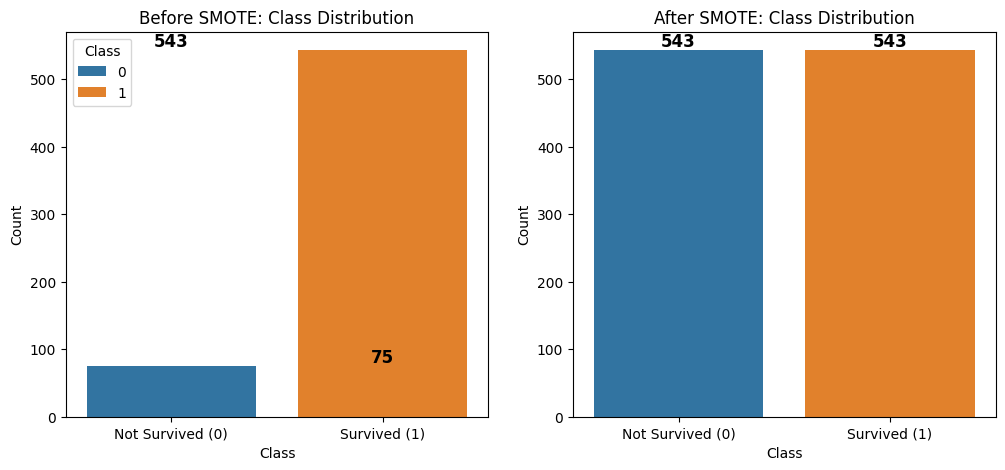

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

# Original Class Distribution (Before SMOTE)
original_counts = Counter(y)
df_original = pd.DataFrame.from_dict(original_counts, orient='index', columns=['Count']).reset_index()
df_original.columns = ['Class', 'Count']

# Resampled Class Distribution (After SMOTE)
resampled_counts = Counter(y_resampled)
df_resampled = pd.DataFrame.from_dict(resampled_counts, orient='index', columns=['Count']).reset_index()
df_resampled.columns = ['Class', 'Count']

# Plot Before & After Distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
sns.barplot(data=df_original, x="Class", y="Count", ax=ax[0], hue="Class", dodge=False)
ax[0].set_title("Before SMOTE: Class Distribution")
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(["Not Survived (0)", "Survived (1)"])
for i, v in enumerate(df_original["Count"]):
    ax[0].text(i, v + 5, str(v), ha='center', fontsize=12, fontweight='bold')

# After SMOTE
sns.barplot(data=df_resampled, x="Class", y="Count", ax=ax[1], hue="Class", dodge=False)
ax[1].set_title("After SMOTE: Class Distribution")
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(["Not Survived (0)", "Survived (1)"])
for i, v in enumerate(df_resampled["Count"]):
    ax[1].text(i, v + 5, str(v), ha='center', fontsize=12, fontweight='bold')

plt.legend([],[], frameon=False)  # Remove redundant legend
plt.show()


## Define an Improved PyTorch Dataset & Model

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Create PyTorch Dataset
class ClinicalDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Dataloaders
batch_size = 32
train_dataset = ClinicalDataset(X_train, y_train)
test_dataset = ClinicalDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define Improved MLP Model
class MLPClassifier(nn.Module):
    def __init__(self, input_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)  # Batch Normalization
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)  # Dropout for regularization

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(64, 2)  # Binary classification (Survival/No Survival)

    def forward(self, x):
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x


# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPClassifier(input_size=X.shape[1]).to(device)

# Loss Function & Optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 6.0]).to(device))  # Weighted loss for imbalance
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
pwd

'/workspace/Diploma_Project'

##  Train the Model

In [18]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, balanced_accuracy_score

# Define optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Create a directory to save checkpoints
checkpoint_dir = '/workspace/Diploma_Project/EHR/EHR_model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Training loop with checkpoint saving
num_epochs = 50
train_losses, train_accuracies, train_balanced_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()  # Set to training mode
    correct, total, running_loss = 0, 0, 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        # Store predictions and labels for balanced accuracy
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    epoch_balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    train_balanced_accuracies.append(epoch_balanced_acc)

    # Reduce learning rate if loss does not improve
    scheduler.step(epoch_loss)

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': epoch_loss,
            'accuracy': epoch_acc,
            'balanced_accuracy': epoch_balanced_acc,
        }, checkpoint_path)
        print(f"Saved checkpoint to {checkpoint_path}")

    # Print loss & accuracy every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Balanced Accuracy: {epoch_balanced_acc:.4f}")

# Save the final model
final_model_path = os.path.join(checkpoint_dir, 'final_model.pth')
torch.save(model.state_dict(), final_model_path)
print(f"Saved final model to {final_model_path}")

# Print final training metrics
final_acc = train_accuracies[-1]
final_balanced_acc = train_balanced_accuracies[-1]
print(f"\nFinal Training Metrics:")
print(f"Accuracy: {final_acc:.4f}")
print(f"Balanced Accuracy: {final_balanced_acc:.4f}")

/workspace/new_env_outside/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Saved checkpoint to /workspace/Diploma_Project/EHR/EHR_model_checkpoints/checkpoint_epoch_5.pth
Epoch 5/50 - Loss: 0.3029, Accuracy: 0.5518, Balanced Accuracy: 0.5518
Saved checkpoint to /workspace/Diploma_Project/EHR/EHR_model_checkpoints/checkpoint_epoch_10.pth
Epoch 10/50 - Loss: 0.2446, Accuracy: 0.7143, Balanced Accuracy: 0.7143
Saved checkpoint to /workspace/Diploma_Project/EHR/EHR_model_checkpoints/checkpoint_epoch_15.pth
Epoch 15/50 - Loss: 0.2443, Accuracy: 0.7212, Balanced Accuracy: 0.7212
Saved checkpoint to /workspace/Diploma_Project/EHR/EHR_model_checkpoints/checkpoint_epoch_20.pth
Epoch 20/50 - Loss: 0.2268, Accuracy: 0.7903, Balanced Accuracy: 0.7903
Saved checkpoint to /workspace/Diploma_Project/EHR/EHR_model_checkpoints/checkpoint_epoch_25.pth
Epoch 25/50 - Loss: 0.2198, Accuracy: 0.7765, Balanced Accuracy: 0.7765
Saved checkpoint to /workspace/Diploma_Project/EHR/EHR_model_checkpoints/checkpoint_epoch_30.pth
Epoch 30/50 - Loss: 0.2098, Accuracy: 0.7730, Balanced Accur

In [38]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Define optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Create a directory to save checkpoints
checkpoint_dir = '/workspace/Diploma_Project/EHR/EHR_model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Training loop with checkpoint saving
num_epochs = 50
train_losses, train_accuracies = [], []

for epoch in range(num_epochs):
    model.train()  # Set to training mode
    correct, total, running_loss = 0, 0, 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Reduce learning rate if loss does not improve
    scheduler.step(epoch_loss)

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': epoch_loss,
            'accuracy': epoch_acc,
        }, checkpoint_path)
        print(f"Saved checkpoint to {checkpoint_path}")

    # Print loss & accuracy every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Save the final model
final_model_path = os.path.join(checkpoint_dir, 'final_model.pth')
torch.save(model.state_dict(), final_model_path)
print(f"Saved final model to {final_model_path}")

Saved checkpoint to /workspace/Diploma_Project/EHR/EHR_model_checkpoints/checkpoint_epoch_5.pth
Epoch 5/50 - Loss: 0.2951, Accuracy: 0.5968
Saved checkpoint to /workspace/Diploma_Project/EHR/EHR_model_checkpoints/checkpoint_epoch_10.pth
Epoch 10/50 - Loss: 0.2669, Accuracy: 0.7707
Saved checkpoint to /workspace/Diploma_Project/EHR/EHR_model_checkpoints/checkpoint_epoch_15.pth
Epoch 15/50 - Loss: 0.2584, Accuracy: 0.7373
Saved checkpoint to /workspace/Diploma_Project/EHR/EHR_model_checkpoints/checkpoint_epoch_20.pth
Epoch 20/50 - Loss: 0.2362, Accuracy: 0.7800
Saved checkpoint to /workspace/Diploma_Project/EHR/EHR_model_checkpoints/checkpoint_epoch_25.pth
Epoch 25/50 - Loss: 0.2067, Accuracy: 0.7995
Saved checkpoint to /workspace/Diploma_Project/EHR/EHR_model_checkpoints/checkpoint_epoch_30.pth
Epoch 30/50 - Loss: 0.2310, Accuracy: 0.8168
Saved checkpoint to /workspace/Diploma_Project/EHR/EHR_model_checkpoints/checkpoint_epoch_35.pth
Epoch 35/50 - Loss: 0.1927, Accuracy: 0.8191
Saved ch

## ✅ Final Refined Code — With Embedding Extraction


🔍 Output:

- ehr_fc3_embeddings.npy: Numpy array of shape (num_patients, 64)
- ehr_fc3_embeddings.csv: Same data in CSV format for quick inspection or use with pandas

These embeddings are now ready to be fused with WSI, CT, or MRI feature representations.

In [39]:
# ----------------------------
# Extract per-patient fc3 embeddings from final trained model
# ----------------------------

# Reload trained model (to be sure)
model = MLPClassifier(input_size=X.shape[1])
model.load_state_dict(torch.load(final_model_path))
model.to(device)
model.eval()

# Prepare full dataset for embedding extraction (X_resampled = SMOTE-balanced features)
full_dataset = ClinicalDataset(X_resampled, y_resampled)
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)

# Extract embeddings
ehr_fc3_embeddings = []

with torch.no_grad():
    for inputs, _ in full_loader:
        inputs = inputs.to(device)
        x = model.relu1(model.bn1(model.fc1(inputs)))
        x = model.dropout1(x)
        x = model.relu2(model.bn2(model.fc2(x)))
        x = model.dropout2(x)
        x = model.relu3(model.fc3(x))  # <- fc3 layer output
        ehr_fc3_embeddings.append(x.cpu())

ehr_fc3_embeddings = torch.cat(ehr_fc3_embeddings, dim=0).numpy()

# Save embeddings
embedding_dir = "/workspace/Diploma_Project/EHR"
os.makedirs(embedding_dir, exist_ok=True)

np.save(os.path.join(embedding_dir, "ehr_fc3_embeddings.npy"), ehr_fc3_embeddings)
pd.DataFrame(ehr_fc3_embeddings).to_csv(os.path.join(embedding_dir, "ehr_fc3_embeddings.csv"), index=False)

print(f"✅ EHR fc3 embeddings extracted and saved. Shape: {ehr_fc3_embeddings.shape}")

✅ EHR fc3 embeddings extracted and saved. Shape: (1086, 64)


/tmp/ipykernel_464348/1169719585.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(final_model_path))


## Plot Training Performance (Accuracy & Loss Curves)

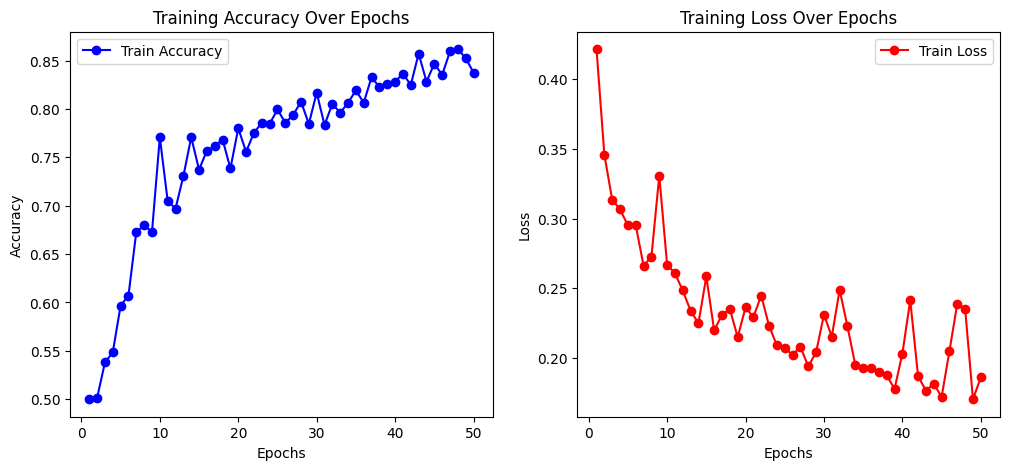

In [40]:
# Plot Train Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy", marker='o', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

plt.show()


##  Evaluate Model on Test Data

In [41]:
# Evaluate on test set
model.eval()  # Set model to evaluation mode
correct, total, running_loss = 0, 0, 0.0
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        probabilities = F.softmax(outputs, dim=1)[:, 1]  # Get probability for positive class

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

# Compute final test accuracy and loss
test_loss = running_loss / len(test_loader)
test_accuracy = correct / total

print(f"\n🔹 Test Loss: {test_loss:.4f}")
print(f"🔹 Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\n🔹 Classification Report:\n", classification_report(all_labels, all_preds))



🔹 Test Loss: 0.1270
🔹 Test Accuracy: 0.9220

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92       109
           1       0.89      0.96      0.93       109

    accuracy                           0.92       218
   macro avg       0.92      0.92      0.92       218
weighted avg       0.92      0.92      0.92       218



## Plot Evaluation Metrics (Confusion Matrix & ROC Curve)

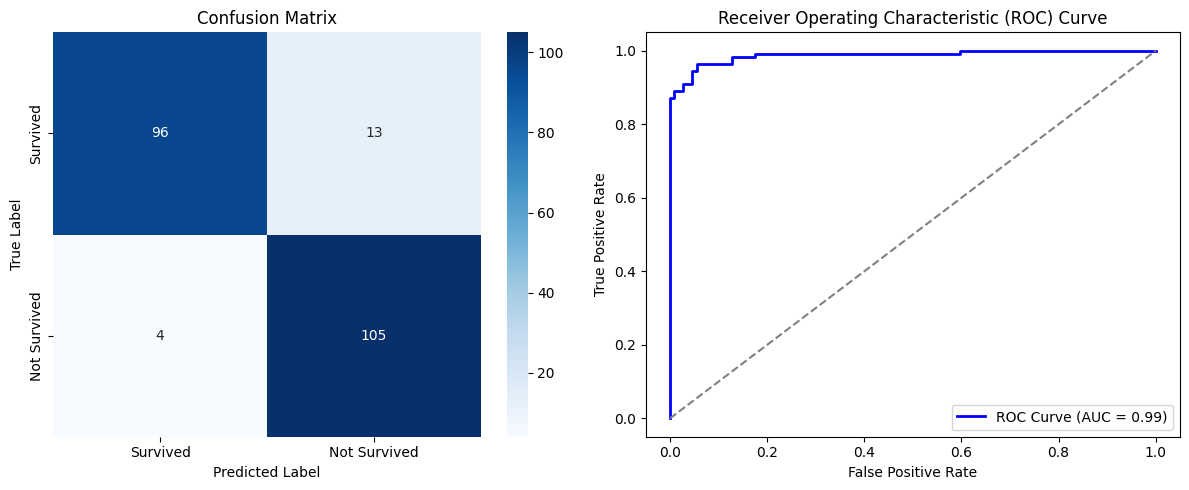

In [42]:
plt.figure(figsize=(12, 5))

# Confusion Matrix on the left
plt.subplot(1, 2, 1)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Survived", "Not Survived"], yticklabels=["Survived", "Not Survived"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# ROC Curve on the right
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


## Compare Training vs. Test Results in a Single Figure

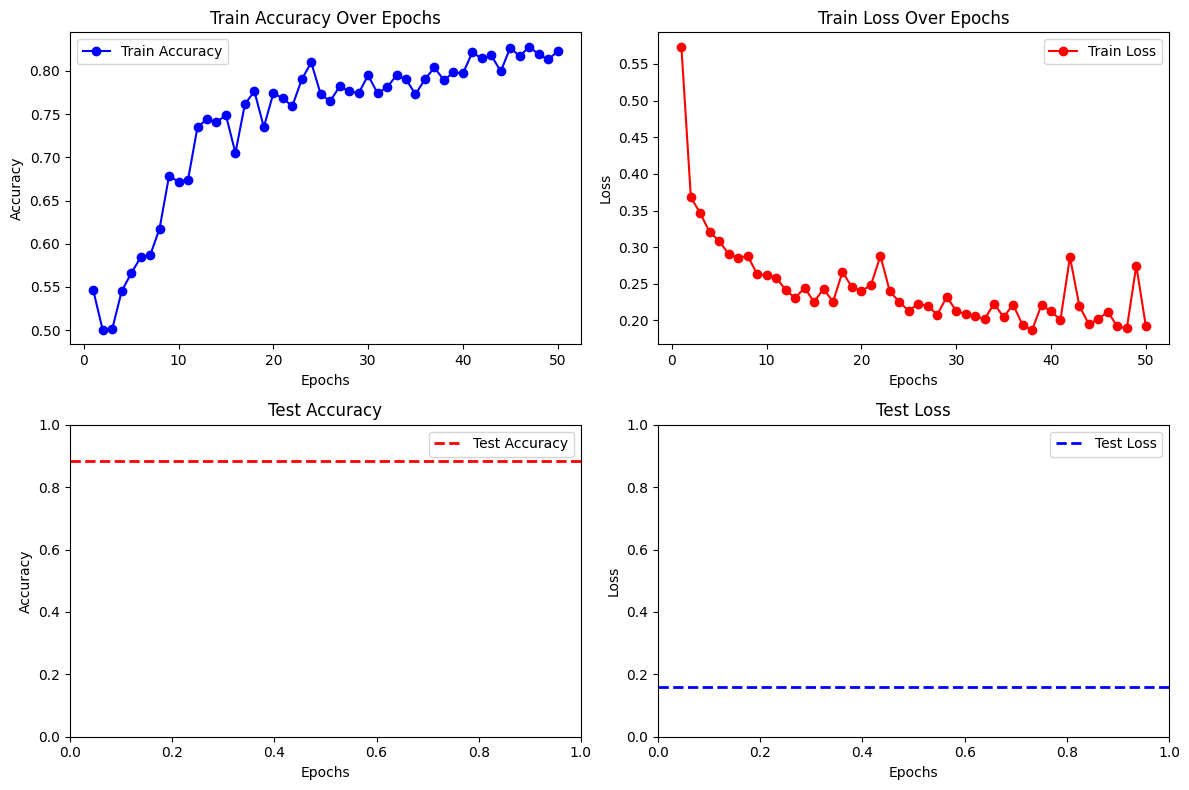

In [29]:
plt.figure(figsize=(12, 8))

# Train Accuracy
plt.subplot(2, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy", marker='o', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train Accuracy Over Epochs")
plt.legend()

# Train Loss
plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train Loss Over Epochs")
plt.legend()

# Test Accuracy
plt.subplot(2, 2, 3)
plt.axhline(y=test_accuracy, color='r', linestyle='--', label="Test Accuracy", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.legend()

# Test Loss
plt.subplot(2, 2, 4)
plt.axhline(y=test_loss, color='b', linestyle='--', label="Test Loss", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Test Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [1]:
pwd

'/workspace/Diploma_Project'

# Below is code to generate ploting images of traning of clam for WSI 

In [1]:
pwd

'/workspace/Diploma_Project'

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Path to parent results directory (change if needed)
base_dir = "/workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1"

# Number of folds
k_folds = 10

# Metrics to plot
metrics = {
    'train_loss': 'Train Loss',
    'train_inst_loss': 'Train Instance Loss',
    'val_loss': 'Validation Loss',
    'val_auc': 'Validation AUC',
    'val_error': 'Validation Error',
    'val_inst_loss': 'Validation Instance Loss',
}

# Plot each metric
for key, label in metrics.items():
    plt.figure(figsize=(10, 6))

    for fold in range(k_folds):
        csv_path = os.path.join(base_dir, str(fold), "training_log.csv")
        if not os.path.exists(csv_path):
            print(f"⚠️ File not found for fold {fold}: {csv_path}")
            continue

        df = pd.read_csv(csv_path)
        if key in df.columns:
            plt.plot(df['epoch'], df[key], label=f"Fold {fold}")
        else:
            print(f"⚠️ '{key}' not found in {csv_path}")

    plt.title(f"{label} over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(label)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save each figure
    out_path = os.path.join(base_dir, f"{key}_plot.png")
    plt.savefig(out_path)
    print(f"✅ Saved: {out_path}")
    plt.close()


✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/train_loss_plot.png
✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/train_inst_loss_plot.png
✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/val_loss_plot.png
✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/val_auc_plot.png
✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/val_error_plot.png
✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/val_inst_loss_plot.png


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Base directory containing fold folders
base_dir = "/workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1"
k_folds = 10

# Store loaded DataFrames
logs = []

# Load data from all folds
for fold in range(k_folds):
    csv_path = os.path.join(base_dir, str(fold), "training_log.csv")
    if not os.path.exists(csv_path):
        print(f"⚠️ File not found for fold {fold}: {csv_path}")
        continue
    df = pd.read_csv(csv_path)
    logs.append(df)

# Metrics to plot individually
metrics = {
    'train_loss': 'Train Loss',
    'train_inst_loss': 'Train Instance Loss',
    'val_loss': 'Validation Loss',
    'val_auc': 'Validation AUC',
    'val_error': 'Validation Error',
    'val_inst_loss': 'Validation Instance Loss',
}

# Plot each metric individually per fold
for key, label in metrics.items():
    plt.figure(figsize=(10, 6))
    for fold, df in enumerate(logs):
        if key in df.columns:
            plt.plot(df['epoch'], df[key], label=f'Fold {fold}')
    plt.title(f"{label} over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(label)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    out_path = os.path.join(base_dir, f"{key}_plot.png")
    plt.savefig(out_path)
    print(f"✅ Saved: {out_path}")
    plt.close()

# ➕ Additional: Train vs Val Loss overlay
plt.figure(figsize=(12, 6))
for fold, df in enumerate(logs):
    if 'train_loss' in df.columns and 'val_loss' in df.columns:
        plt.plot(df['epoch'], df['train_loss'], label=f'Train Fold {fold}', linestyle='--')
        plt.plot(df['epoch'], df['val_loss'], label=f'Val Fold {fold}', linestyle='-')
plt.title("Train vs Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(ncol=2, fontsize=9)
plt.grid(True)
plt.tight_layout()
out_path = os.path.join(base_dir, "train_vs_val_loss_overlay.png")
plt.savefig(out_path)
print(f"✅ Saved: {out_path}")
plt.close()

# ➕ Additional: Boxplot of final validation AUC across folds
final_val_aucs = [df['val_auc'].iloc[-1] for df in logs if 'val_auc' in df.columns]
plt.figure(figsize=(8, 5))
plt.boxplot(final_val_aucs)
plt.title("Final Validation AUC Distribution Across Folds")
plt.ylabel("AUC")
plt.grid(True)
out_path = os.path.join(base_dir, "val_auc_boxplot.png")
plt.savefig(out_path)
print(f"✅ Saved: {out_path}")
plt.close()


✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/train_loss_plot.png
✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/train_inst_loss_plot.png
✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/val_loss_plot.png
✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/val_auc_plot.png
✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/val_error_plot.png
✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/val_inst_loss_plot.png
✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/train_vs_val_loss_overlay.png
✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/val_auc_boxplot.png


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_dir = "/workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1"
k_folds = 10

logs = []
val_aucs_final = []
val_aucs_best = []
early_stop_epochs = []

for fold in range(k_folds):
    csv_path = os.path.join(base_dir, str(fold), "training_log.csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        logs.append(df)
        if 'val_auc' in df.columns:
            val_aucs_final.append(df['val_auc'].iloc[-1])
            val_aucs_best.append(df['val_auc'].max())
        early_stop_epochs.append(len(df))
    else:
        print(f"⚠️ Missing: {csv_path}")
        logs.append(None)
        val_aucs_final.append(None)
        val_aucs_best.append(None)
        early_stop_epochs.append(None)

# Standard Metric Plots
metrics = {
    'train_loss': 'Train Loss',
    'train_inst_loss': 'Train Instance Loss',
    'val_loss': 'Validation Loss',
    'val_auc': 'Validation AUC',
    'val_error': 'Validation Error',
    'val_inst_loss': 'Validation Instance Loss',
}

for key, label in metrics.items():
    plt.figure(figsize=(10, 6))
    for fold, df in enumerate(logs):
        if df is not None and key in df.columns:
            plt.plot(df['epoch'], df[key], label=f'Fold {fold}')
    plt.title(f"{label} over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(label)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, f"{key}_plot.png"))
    plt.close()

# ➕ Overlay: Train vs Val Loss
plt.figure(figsize=(12, 6))
for fold, df in enumerate(logs):
    if df is not None and 'train_loss' in df.columns and 'val_loss' in df.columns:
        plt.plot(df['epoch'], df['train_loss'], label=f'Train Fold {fold}', linestyle='--')
        plt.plot(df['epoch'], df['val_loss'], label=f'Val Fold {fold}', linestyle='-')
plt.title("Train vs Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(ncol=2, fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, "train_vs_val_loss_overlay.png"))
plt.close()

# ➕ Boxplot: Final Val AUCs
valid_aucs = [x for x in val_aucs_final if x is not None]
plt.figure(figsize=(8, 5))
plt.boxplot(valid_aucs)
plt.title("Final Validation AUC Distribution")
plt.ylabel("AUC")
plt.grid(True)
plt.savefig(os.path.join(base_dir, "val_auc_boxplot.png"))
plt.close()

# ➕ Bar Chart: Final Val AUC per Fold
plt.figure(figsize=(10, 6))
plt.bar(range(k_folds), val_aucs_final, color='skyblue')
plt.title("Final Validation AUC per Fold")
plt.xlabel("Fold")
plt.ylabel("Final Val AUC")
plt.xticks(range(k_folds))
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, "final_val_auc_per_fold.png"))
plt.close()

# ➕ Bar Chart: Best Val AUC per Fold
plt.figure(figsize=(10, 6))
plt.bar(range(k_folds), val_aucs_best, color='green')
plt.title("Best Validation AUC per Fold")
plt.xlabel("Fold")
plt.ylabel("Best Val AUC")
plt.xticks(range(k_folds))
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, "best_val_auc_per_fold.png"))
plt.close()

# ➕ Early Stopping Epochs per Fold
plt.figure(figsize=(10, 6))
plt.bar(range(k_folds), early_stop_epochs, color='orange')
plt.title("Early Stopping Epoch per Fold")
plt.xlabel("Fold")
plt.ylabel("Epoch Stopped")
plt.xticks(range(k_folds))
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, "early_stopping_epoch_per_fold.png"))
plt.close()


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Path to summary.csv
summary_path = "/workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/summary.csv"
output_dir = os.path.dirname(summary_path)

# Load data
df = pd.read_csv(summary_path)

# Plot 1: Bar plots for each metric
metrics = ['test_auc', 'val_auc', 'test_acc', 'val_acc']
df_plot = df.set_index('folds')

plt.figure(figsize=(12, 6))
df_plot[metrics].plot(kind='bar')
plt.title("Fold-wise AUC and Accuracy")
plt.ylabel("Score")
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "barplot_metrics.png"))
plt.close()
print("✅ Saved: barplot_metrics.png")

# Plot 2: Scatter plot - Validation AUC vs Test AUC
plt.figure(figsize=(6, 5))
plt.scatter(df['val_auc'], df['test_auc'], color='teal')
plt.plot([df['val_auc'].min(), df['val_auc'].max()], [df['val_auc'].min(), df['val_auc'].max()], linestyle='--', color='gray')
plt.xlabel("Validation AUC")
plt.ylabel("Test AUC")
plt.title("Validation AUC vs Test AUC")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "val_vs_test_auc_scatter.png"))
plt.close()
print("✅ Saved: val_vs_test_auc_scatter.png")

# Plot 3: Error bar on Test AUC
mean_auc = df['test_auc'].mean()
std_auc = df['test_auc'].std()

plt.figure(figsize=(8, 5))
plt.bar(df['folds'], df['test_auc'], color='cornflowerblue', yerr=std_auc, capsize=4)
plt.axhline(mean_auc, linestyle='--', color='red', label=f"Mean AUC = {mean_auc:.3f}")
plt.xlabel("Fold")
plt.ylabel("Test AUC")
plt.title("Test AUC per Fold with Std Deviation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "test_auc_std_plot.png"))
plt.close()
print("✅ Saved: test_auc_std_plot.png")


✅ Saved: barplot_metrics.png
✅ Saved: val_vs_test_auc_scatter.png
✅ Saved: test_auc_std_plot.png


<Figure size 1200x600 with 0 Axes>

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Config ===
base_dir = "/workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1"
summary_path = os.path.join(base_dir, "summary.csv")
output_dir = base_dir
k_folds = 10

# === Load summary.csv for final evaluation metrics ===
df = pd.read_csv(summary_path)

# Plot 1: Bar plots for evaluation metrics (AUC + Accuracy)
metrics = ['test_auc', 'val_auc', 'test_acc', 'val_acc']
df_plot = df.set_index('folds')

plt.figure(figsize=(12, 6))
df_plot[metrics].plot(kind='bar')
plt.title("Fold-wise AUC and Accuracy")
plt.ylabel("Score")
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "barplot_metrics.png"))
plt.close()
print("✅ Saved: barplot_metrics.png")

# Plot 2: Scatter plot - Validation AUC vs Test AUC
plt.figure(figsize=(6, 5))
plt.scatter(df['val_auc'], df['test_auc'], color='teal')
plt.plot([df['val_auc'].min(), df['val_auc'].max()], [df['val_auc'].min(), df['val_auc'].max()], linestyle='--', color='gray')
plt.xlabel("Validation AUC")
plt.ylabel("Test AUC")
plt.title("Validation AUC vs Test AUC")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "val_vs_test_auc_scatter.png"))
plt.close()
print("✅ Saved: val_vs_test_auc_scatter.png")

# Plot 3: Error bar on Test AUC
mean_auc = df['test_auc'].mean()
std_auc = df['test_auc'].std()

plt.figure(figsize=(8, 5))
plt.bar(df['folds'], df['test_auc'], color='cornflowerblue', yerr=std_auc, capsize=4)
plt.axhline(mean_auc, linestyle='--', color='red', label=f"Mean AUC = {mean_auc:.3f}")
plt.xlabel("Fold")
plt.ylabel("Test AUC")
plt.title("Test AUC per Fold with Std Deviation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "test_auc_std_plot.png"))
plt.close()
print("✅ Saved: test_auc_std_plot.png")

# === Training plots from each fold's training_log.csv ===
training_metrics = {
    'train_loss': 'Train Loss',
    'train_inst_loss': 'Train Instance Loss',
    'val_loss': 'Validation Loss',
    'val_auc': 'Validation AUC',
    'val_error': 'Validation Error',
    'val_inst_loss': 'Validation Instance Loss',
}

for key, label in training_metrics.items():
    plt.figure(figsize=(10, 6))

    for fold in range(k_folds):
        csv_path = os.path.join(base_dir, str(fold), "training_log.csv")
        if not os.path.exists(csv_path):
            print(f"⚠️ training_log.csv not found for fold {fold}")
            continue

        df_log = pd.read_csv(csv_path)
        if key in df_log.columns:
            plt.plot(df_log['epoch'], df_log[key], label=f"Fold {fold}")
        else:
            print(f"⚠️ '{key}' not found in {csv_path}")

    plt.title(f"{label} over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(label)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    out_path = os.path.join(output_dir, f"{key}_plot.png")
    plt.savefig(out_path)
    print(f"✅ Saved: {out_path}")
    plt.close()


✅ Saved: barplot_metrics.png
✅ Saved: val_vs_test_auc_scatter.png
✅ Saved: test_auc_std_plot.png
✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/train_loss_plot.png
✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/train_inst_loss_plot.png
✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/val_loss_plot.png
✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/val_auc_plot.png
✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/val_error_plot.png
✅ Saved: /workspace/Diploma_Project/CLAM/results/tumor_vs_normal_CLAM_s1/val_inst_loss_plot.png


<Figure size 1200x600 with 0 Axes>